In [1]:
import random
import os
import matplotlib.pylab as plt
from glob import glob
import numpy as np
import webcolors
from PIL import Image
import cv2
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 15, 30

In [2]:
def get_image(path):
    
    img = Image.open(path)
    img = img.resize((640,256))
    img = np.array(img)
    
    return img

In [3]:
from albumentations import (
        OneOf,
        Blur,
        RandomGamma,
        HueSaturationValue,
        RGBShift,
        RandomBrightness,
        RandomContrast,
        MedianBlur,
        CLAHE
    )
    
aug = OneOf([
        Blur(blur_limit=5, p=1.),
        RandomGamma(gamma_limit=(50, 150), p=1.),
        HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=1.),
        RGBShift(r_shift_limit=15, g_shift_limit=5, b_shift_limit=15, p=1.),
        RandomBrightness(limit=.25, p=1.),
        RandomContrast(limit=.25, p=1.),
        MedianBlur(blur_limit=5, p=1.),
        CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.)
        ], p=1.)

In [4]:
def augment(image, aug=aug):

    augmented = aug(image=image)
    image_augmented = augmented['image']

    return image_augmented

In [30]:
def vis(img1, img2):
    
    f, ax = plt.subplots(2, 1, figsize=(15, 15))

    ax[0].imshow(img1)
    ax[1].imshow(img2)

In [6]:
from segmentation_models import Linknet

num_classes = 3
input_shape = (256,640,3)

backbone = 'resnet18'

model = Linknet(backbone_name=backbone, input_shape=input_shape, classes=num_classes, activation='softmax')

model.load_weights("/home/kenny/Desktop/lanes-segmentation/weights/innopolis/linknet-resnet18_overfit/2019-01-21 11-14-12.hdf5")

In [20]:
from segmentation_models.backbones import get_preprocessing

preprocessing_fn = get_preprocessing('resnet18')

name = '2018-12-10-102'
# name = '2018-12-10-4'
# name = '2018-11-30-85'
# name = '2018-12-04-123'

path = '/home/kenny/Desktop/lanes-segmentation/data/images/innopolis/' + name + '.png'

img = get_image(path)
img_aug = augment(img)
img = np.expand_dims(img, axis=0) 
img_aug = np.expand_dims(img_aug, axis=0) 
img = preprocessing_fn(img)
img_aug = preprocessing_fn(img_aug)

In [58]:
pred = model.predict(img)
pred = pred.squeeze()

pred_aug = model.predict(img_aug)
pred_aug = pred_aug.squeeze()

In [59]:
msk = get_image(path.replace("image","label"))

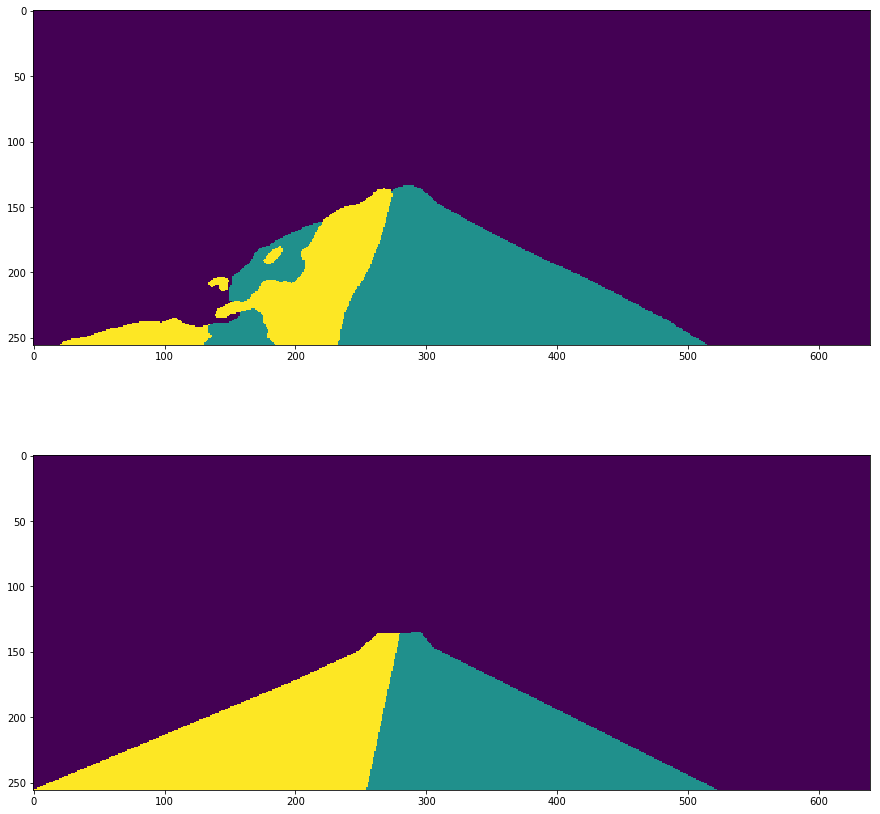

In [60]:
vis(np.argmax(pred, axis=-1), msk)

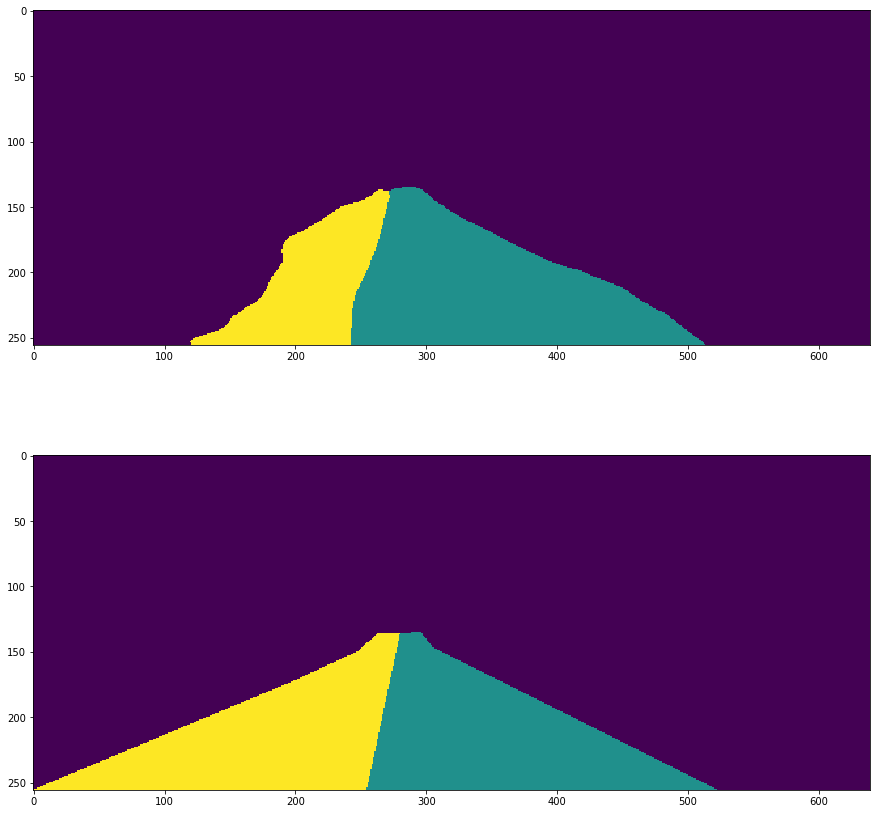

In [61]:
vis(np.argmax(pred_aug, axis=-1), msk)

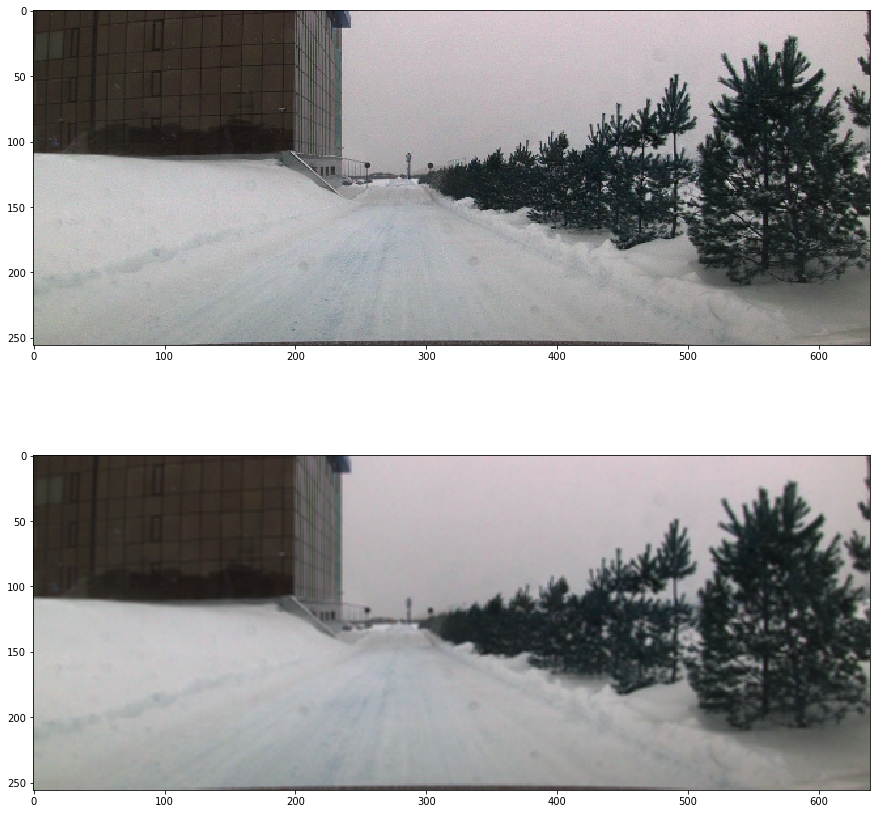

In [62]:
vis(img.squeeze(), img_aug.squeeze())

In [103]:
from keras.utils import to_categorical

msk_ = to_categorical(msk)
pred_ = to_categorical(np.argmax(pred, axis=-1))
pred_aug_ = to_categorical(np.argmax(pred_aug, axis=-1))

intersection = np.logical_and(msk_, pred_)
union = np.logical_or(msk_, pred_)
iou_score = np.sum(intersection) / np.sum(union)

print(iou_score)

intersection = np.logical_and(msk_, pred_aug_)
union = np.logical_or(msk_, pred_aug_)
iou_score_aug = np.sum(intersection) / np.sum(union)

print(iou_score_aug)

0.9125217411605402
0.9072452970758056


In [79]:
def pixel_accuracy(eval_segm, gt_segm):
    '''
    sum_i(n_ii) / sum_i(t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    sum_n_ii = 0
    sum_t_i  = 0

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        sum_n_ii += np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        sum_t_i  += np.sum(curr_gt_mask)
 
    if (sum_t_i == 0):
        pixel_accuracy_ = 0
    else:
        pixel_accuracy_ = sum_n_ii / sum_t_i

    return pixel_accuracy_

def mean_accuracy(eval_segm, gt_segm):
    '''
    (1/n_cl) sum_i(n_ii/t_i)
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    accuracy = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
 
        if (t_i != 0):
            accuracy[i] = n_ii / t_i

    mean_accuracy_ = np.mean(accuracy)
    return mean_accuracy_

def mean_IU(eval_segm, gt_segm):
    '''
    (1/n_cl) * sum_i(n_ii / (t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl   = union_classes(eval_segm, gt_segm)
    _, n_cl_gt = extract_classes(gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    IU = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        IU[i] = n_ii / (t_i + n_ij - n_ii)
 
    mean_IU_ = np.sum(IU) / n_cl_gt
    return mean_IU_

def frequency_weighted_IU(eval_segm, gt_segm):
    '''
    sum_k(t_k)^(-1) * sum_i((t_i*n_ii)/(t_i + sum_j(n_ji) - n_ii))
    '''

    check_size(eval_segm, gt_segm)

    cl, n_cl = union_classes(eval_segm, gt_segm)
    eval_mask, gt_mask = extract_both_masks(eval_segm, gt_segm, cl, n_cl)

    frequency_weighted_IU_ = list([0]) * n_cl

    for i, c in enumerate(cl):
        curr_eval_mask = eval_mask[i, :, :]
        curr_gt_mask = gt_mask[i, :, :]
 
        if (np.sum(curr_eval_mask) == 0) or (np.sum(curr_gt_mask) == 0):
            continue

        n_ii = np.sum(np.logical_and(curr_eval_mask, curr_gt_mask))
        t_i  = np.sum(curr_gt_mask)
        n_ij = np.sum(curr_eval_mask)

        frequency_weighted_IU_[i] = (t_i * n_ii) / (t_i + n_ij - n_ii)
 
    sum_k_t_k = get_pixel_area(eval_segm)
    
    frequency_weighted_IU_ = np.sum(frequency_weighted_IU_) / sum_k_t_k
    return frequency_weighted_IU_

'''
Auxiliary functions used during evaluation.
'''
def get_pixel_area(segm):
    return segm.shape[0] * segm.shape[1]

def extract_both_masks(eval_segm, gt_segm, cl, n_cl):
    eval_mask = extract_masks(eval_segm, cl, n_cl)
    gt_mask   = extract_masks(gt_segm, cl, n_cl)

    return eval_mask, gt_mask

def extract_classes(segm):
    cl = np.unique(segm)
    n_cl = len(cl)

    return cl, n_cl

def union_classes(eval_segm, gt_segm):
    eval_cl, _ = extract_classes(eval_segm)
    gt_cl, _   = extract_classes(gt_segm)

    cl = np.union1d(eval_cl, gt_cl)
    n_cl = len(cl)

    return cl, n_cl

def extract_masks(segm, cl, n_cl):
    h, w  = segm_size(segm)
    masks = np.zeros((n_cl, h, w))

    for i, c in enumerate(cl):
        masks[i, :, :] = segm == c

    return masks

def segm_size(segm):
    try:
        height = segm.shape[0]
        width  = segm.shape[1]
    except IndexError:
        raise

    return height, width

def check_size(eval_segm, gt_segm):
    h_e, w_e = segm_size(eval_segm)
    h_g, w_g = segm_size(gt_segm)

    if (h_e != h_g) or (w_e != w_g):
        raise EvalSegErr("DiffDim: Different dimensions of matrices!")

'''
Exceptions
'''
class EvalSegErr(Exception):
    def __init__(self, value):
        self.value = value

    def __str__(self):
        return repr(self.value)

In [93]:
pixel_accuracy(np.argmax(pred, axis=-1), msk)

0.95426025390625

In [94]:
pixel_accuracy(np.argmax(pred_aug, axis=-1), msk)

0.9513671875

In [95]:
mean_accuracy(np.argmax(pred, axis=-1), msk)

0.8412323322860692

In [96]:
mean_accuracy(np.argmax(pred_aug, axis=-1), msk)

0.8374054116274775

In [97]:
mean_IU(np.argmax(pred, axis=-1), msk)

0.7646796321168238

In [98]:
mean_IU(np.argmax(pred_aug, axis=-1), msk)

0.7885015265662071

In [101]:
frequency_weighted_IU(np.argmax(pred, axis=-1), msk)

0.9147632127870027

In [102]:
frequency_weighted_IU(np.argmax(pred_aug, axis=-1), msk)

0.9060999030867514

In [191]:
def tptnfpfn(pred_labels, true_labels):
    # True Positive (TP): we predict a label of 1 (positive), and the true label is 1.
    TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))

    # True Negative (TN): we predict a label of 0 (negative), and the true label is 0.
    TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))

    # False Positive (FP): we predict a label of 1 (positive), but the true label is 0.
    FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))

    # False Negative (FN): we predict a label of 0 (negative), but the true label is 1.
    FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
    
    # true positive / (true positive + false positive + false negative)

    print('TP: %i, FP: %i, TN: %i, FN: %i' % (TP,FP,TN,FN))
    
    IU = TP/(TP+2*FP+FN)
    
    print(IU)
    
    return IU

In [189]:
cl = 1

pred_labels = pred_[...,cl]
pred_aug_labels = pred_aug_[...,cl]
true_labels = msk_[...,cl]

tptnfpfn(pred_labels, true_labels)
tptnfpfn(pred_aug_labels, true_labels)

TP: 16247, FP: 4234, TN: 143201, FN: 158
0.1607261215808478
TP: 16285, FP: 1800, TN: 145635, FN: 120
0.31075279076424006


0.31075279076424006

In [190]:
mIU = 0
mIU_aug = 0

for i in range(1,3):
    cl = i

    pred_labels = pred_[...,cl]
    pred_aug_labels = pred_aug_[...,cl]
    true_labels = msk_[...,cl]

    mIU += tptnfpfn(pred_labels, true_labels)/2
    mIU_aug += tptnfpfn(pred_aug_labels, true_labels)/2
    
print(mIU)
print(mIU_aug)

TP: 16247, FP: 4234, TN: 143201, FN: 158
0.1607261215808478
TP: 16285, FP: 1800, TN: 145635, FN: 120
0.31075279076424006
TP: 8159, FP: 89, TN: 148507, FN: 7085
0.4792645676691729
TP: 7988, FP: 154, TN: 148442, FN: 7256
0.4359310194280725
0.31999534462501034
0.3733419050961563


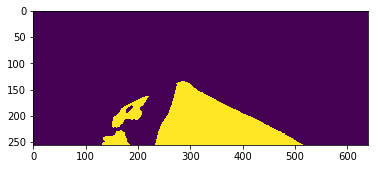

In [164]:
plt.imshow(pred_labels)

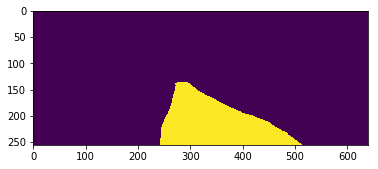

In [165]:
plt.imshow(pred_aug_labels)

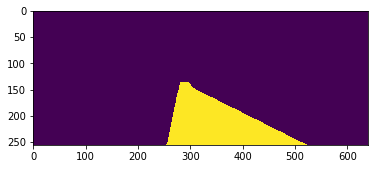

In [166]:
plt.imshow(true_labels)